In [1]:
from tqdm import tqdm
import numpy as np
import random
import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms, models

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
from torch.utils.data import Subset
import re

In [2]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, name="\nVal", get_loss=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(
                output, target.float(), size_average=False).item()  # sum up batch loss
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if get_loss:
        return test_loss
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()

        self.layers += [nn.Conv2d(1, 16,  kernel_size=3),
                        nn.ReLU(inplace=True)]
        self.layers += [nn.Conv2d(16, 16,  kernel_size=3, stride=2),
                        nn.ReLU(inplace=True)]
        self.layers += [nn.Conv2d(16, 32,  kernel_size=3),
                        nn.ReLU(inplace=True)]
        self.layers += [nn.Conv2d(32, 32,  kernel_size=3, stride=2),
                        nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 1)

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        x = self.fc(x)
        return x

In [4]:
from transformers import ViTForImageClassification, ViTConfig, ViTFeatureExtractor

In [5]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [6]:
data_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
      ])

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# device = 'cpu'

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

accs_val = []

for seed in range(1, 51):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)
  model = models.vgg19(pretrained=True)
  model.classifier = nn.Linear(512 * 7 * 7, 1)

  model.to(device).train() 

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
#   optimizer = optim.Adam(model.classifier.parameters(),lr=1e-3)
  optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
#   scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)

  for epoch in range(200):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    scheduler.step() # test(model, device, val_loader, get_loss=True))
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over %d instances on dataset: %s %.2f +- %.2f'%(len(accs_val), data_flag, accs_val.mean(), accs_val.std()))

Using downloaded and verified file: /home/z_yuxian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/z_yuxian/.medmnist/pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.690852
Train Epoch: 5 [0/10 (0%)]	Loss: 0.393641
Train Epoch: 10 [0/10 (0%)]	Loss: 0.148993
Train Epoch: 15 [0/10 (0%)]	Loss: 0.060844
Train Epoch: 20 [0/10 (0%)]	Loss: 0.031391
Train Epoch: 25 [0/10 (0%)]	Loss: 0.019890
Train Epoch: 30 [0/10 (0%)]	Loss: 0.014471
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011635
Train Epoch: 40 [0/10 (0%)]	Loss: 0.010009
Train Epoch: 45 [0/10 (0%)]	Loss: 0.008985
Train Epoch: 50 [0/10 (0%)]	Loss: 0.008282
Train Epoch: 55 [0/10 (0%)]	Loss: 0.007764
Train Epoch: 60 [0/10 (0%)]	Loss: 0.007361
Train Epoch: 65 [0/10 (0%)]	Loss: 0.007032
Train Epoch: 70 [0/10 (0%)]	Loss: 0.006753
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006511
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006296
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006101
Train Epoch: 90

/home/z_yuxian/miniconda3/envs/nn/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.2986, Accuracy: 873/1000 (87.30%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.695669
Train Epoch: 5 [0/10 (0%)]	Loss: 0.309728
Train Epoch: 10 [0/10 (0%)]	Loss: 0.105348
Train Epoch: 15 [0/10 (0%)]	Loss: 0.041362
Train Epoch: 20 [0/10 (0%)]	Loss: 0.021098
Train Epoch: 25 [0/10 (0%)]	Loss: 0.013562
Train Epoch: 30 [0/10 (0%)]	Loss: 0.009999
Train Epoch: 35 [0/10 (0%)]	Loss: 0.008071
Train Epoch: 40 [0/10 (0%)]	Loss: 0.006942
Train Epoch: 45 [0/10 (0%)]	Loss: 0.006234
Train Epoch: 50 [0/10 (0%)]	Loss: 0.005759
Train Epoch: 55 [0/10 (0%)]	Loss: 0.005415
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005150
Train Epoch: 65 [0/10 (0%)]	Loss: 0.004934
Train Epoch: 70 [0/10 (0%)]	Loss: 0.004750
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004589
Train Epoch: 80 [0/10 (0%)]	Loss: 0.004445
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004314
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004194
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004083
Train Epoch: 100 [0/10 (0%)]

Train Epoch: 80 [0/10 (0%)]	Loss: 0.003532
Train Epoch: 85 [0/10 (0%)]	Loss: 0.003444
Train Epoch: 90 [0/10 (0%)]	Loss: 0.003364
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003289
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003218
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003152
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003089
Train Epoch: 115 [0/10 (0%)]	Loss: 0.003030
Train Epoch: 120 [0/10 (0%)]	Loss: 0.002974
Train Epoch: 125 [0/10 (0%)]	Loss: 0.002921
Train Epoch: 130 [0/10 (0%)]	Loss: 0.002870
Train Epoch: 135 [0/10 (0%)]	Loss: 0.002822
Train Epoch: 140 [0/10 (0%)]	Loss: 0.002775
Train Epoch: 145 [0/10 (0%)]	Loss: 0.002731
Train Epoch: 150 [0/10 (0%)]	Loss: 0.002689
Train Epoch: 155 [0/10 (0%)]	Loss: 0.002649
Train Epoch: 160 [0/10 (0%)]	Loss: 0.002610
Train Epoch: 165 [0/10 (0%)]	Loss: 0.002573
Train Epoch: 170 [0/10 (0%)]	Loss: 0.002537
Train Epoch: 175 [0/10 (0%)]	Loss: 0.002503
Train Epoch: 180 [0/10 (0%)]	Loss: 0.002470
Train Epoch: 185 [0/10 (0%)]	Loss: 0.002439
Train Epoch: 190 [0/10 (0%)]	Loss: 0

Train Epoch: 170 [0/10 (0%)]	Loss: 0.002478
Train Epoch: 175 [0/10 (0%)]	Loss: 0.002443
Train Epoch: 180 [0/10 (0%)]	Loss: 0.002410
Train Epoch: 185 [0/10 (0%)]	Loss: 0.002378
Train Epoch: 190 [0/10 (0%)]	Loss: 0.002347
Train Epoch: 195 [0/10 (0%)]	Loss: 0.002318

Val set: Average loss: 0.3257, Accuracy: 854/1000 (85.40%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.715448
Train Epoch: 5 [0/10 (0%)]	Loss: 0.360656
Train Epoch: 10 [0/10 (0%)]	Loss: 0.126665
Train Epoch: 15 [0/10 (0%)]	Loss: 0.050815
Train Epoch: 20 [0/10 (0%)]	Loss: 0.026340
Train Epoch: 25 [0/10 (0%)]	Loss: 0.016895
Train Epoch: 30 [0/10 (0%)]	Loss: 0.012380
Train Epoch: 35 [0/10 (0%)]	Loss: 0.009973
Train Epoch: 40 [0/10 (0%)]	Loss: 0.008585
Train Epoch: 45 [0/10 (0%)]	Loss: 0.007715
Train Epoch: 50 [0/10 (0%)]	Loss: 0.007121
Train Epoch: 55 [0/10 (0%)]	Loss: 0.006685
Train Epoch: 60 [0/10 (0%)]	Loss: 0.006343
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006064
Train Epoch: 70 [0/10 

Train Epoch: 50 [0/10 (0%)]	Loss: 0.007291
Train Epoch: 55 [0/10 (0%)]	Loss: 0.006832
Train Epoch: 60 [0/10 (0%)]	Loss: 0.006473
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006181
Train Epoch: 70 [0/10 (0%)]	Loss: 0.005935
Train Epoch: 75 [0/10 (0%)]	Loss: 0.005722
Train Epoch: 80 [0/10 (0%)]	Loss: 0.005532
Train Epoch: 85 [0/10 (0%)]	Loss: 0.005360
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005203
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005058
Train Epoch: 100 [0/10 (0%)]	Loss: 0.004924
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004800
Train Epoch: 110 [0/10 (0%)]	Loss: 0.004684
Train Epoch: 115 [0/10 (0%)]	Loss: 0.004574
Train Epoch: 120 [0/10 (0%)]	Loss: 0.004471
Train Epoch: 125 [0/10 (0%)]	Loss: 0.004374
Train Epoch: 130 [0/10 (0%)]	Loss: 0.004283
Train Epoch: 135 [0/10 (0%)]	Loss: 0.004196
Train Epoch: 140 [0/10 (0%)]	Loss: 0.004114
Train Epoch: 145 [0/10 (0%)]	Loss: 0.004037
Train Epoch: 150 [0/10 (0%)]	Loss: 0.003963
Train Epoch: 155 [0/10 (0%)]	Loss: 0.003893
Train Epoch: 160 [0/10 (0%)]	Loss: 0.00382

Train Epoch: 145 [0/10 (0%)]	Loss: 0.002672
Train Epoch: 150 [0/10 (0%)]	Loss: 0.002632
Train Epoch: 155 [0/10 (0%)]	Loss: 0.002593
Train Epoch: 160 [0/10 (0%)]	Loss: 0.002556
Train Epoch: 165 [0/10 (0%)]	Loss: 0.002520
Train Epoch: 170 [0/10 (0%)]	Loss: 0.002486
Train Epoch: 175 [0/10 (0%)]	Loss: 0.002453
Train Epoch: 180 [0/10 (0%)]	Loss: 0.002422
Train Epoch: 185 [0/10 (0%)]	Loss: 0.002392
Train Epoch: 190 [0/10 (0%)]	Loss: 0.002362
Train Epoch: 195 [0/10 (0%)]	Loss: 0.002334

Val set: Average loss: 0.3254, Accuracy: 852/1000 (85.20%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.698531
Train Epoch: 5 [0/10 (0%)]	Loss: 0.410591
Train Epoch: 10 [0/10 (0%)]	Loss: 0.157241
Train Epoch: 15 [0/10 (0%)]	Loss: 0.064983
Train Epoch: 20 [0/10 (0%)]	Loss: 0.033701
Train Epoch: 25 [0/10 (0%)]	Loss: 0.021345
Train Epoch: 30 [0/10 (0%)]	Loss: 0.015587
Train Epoch: 35 [0/10 (0%)]	Loss: 0.012553
Train Epoch: 40 [0/10 (0%)]	Loss: 0.010783
Train Epoch: 45 [

Train Epoch: 25 [0/10 (0%)]	Loss: 0.018626
Train Epoch: 30 [0/10 (0%)]	Loss: 0.013630
Train Epoch: 35 [0/10 (0%)]	Loss: 0.011004
Train Epoch: 40 [0/10 (0%)]	Loss: 0.009479
Train Epoch: 45 [0/10 (0%)]	Loss: 0.008510
Train Epoch: 50 [0/10 (0%)]	Loss: 0.007842
Train Epoch: 55 [0/10 (0%)]	Loss: 0.007351
Train Epoch: 60 [0/10 (0%)]	Loss: 0.006968
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006657
Train Epoch: 70 [0/10 (0%)]	Loss: 0.006393
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006163
Train Epoch: 80 [0/10 (0%)]	Loss: 0.005959
Train Epoch: 85 [0/10 (0%)]	Loss: 0.005775
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005606
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005449
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005305
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005170
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005045
Train Epoch: 115 [0/10 (0%)]	Loss: 0.004927
Train Epoch: 120 [0/10 (0%)]	Loss: 0.004815
Train Epoch: 125 [0/10 (0%)]	Loss: 0.004711
Train Epoch: 130 [0/10 (0%)]	Loss: 0.004612
Train Epoch: 135 [0/10 (0%)]	Loss: 0.004518
Tra

Train Epoch: 120 [0/10 (0%)]	Loss: 0.004051
Train Epoch: 125 [0/10 (0%)]	Loss: 0.003968
Train Epoch: 130 [0/10 (0%)]	Loss: 0.003891
Train Epoch: 135 [0/10 (0%)]	Loss: 0.003817
Train Epoch: 140 [0/10 (0%)]	Loss: 0.003747
Train Epoch: 145 [0/10 (0%)]	Loss: 0.003680
Train Epoch: 150 [0/10 (0%)]	Loss: 0.003617
Train Epoch: 155 [0/10 (0%)]	Loss: 0.003556
Train Epoch: 160 [0/10 (0%)]	Loss: 0.003498
Train Epoch: 165 [0/10 (0%)]	Loss: 0.003443
Train Epoch: 170 [0/10 (0%)]	Loss: 0.003391
Train Epoch: 175 [0/10 (0%)]	Loss: 0.003340
Train Epoch: 180 [0/10 (0%)]	Loss: 0.003291
Train Epoch: 185 [0/10 (0%)]	Loss: 0.003245
Train Epoch: 190 [0/10 (0%)]	Loss: 0.003200
Train Epoch: 195 [0/10 (0%)]	Loss: 0.003157

Val set: Average loss: 0.2746, Accuracy: 893/1000 (89.30%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.730732
Train Epoch: 5 [0/10 (0%)]	Loss: 0.408007
Train Epoch: 10 [0/10 (0%)]	Loss: 0.155300
Train Epoch: 15 [0/10 (0%)]	Loss: 0.063784
Train Epoch:

Train Epoch: 0 [0/10 (0%)]	Loss: 0.654784
Train Epoch: 5 [0/10 (0%)]	Loss: 0.314947
Train Epoch: 10 [0/10 (0%)]	Loss: 0.100549
Train Epoch: 15 [0/10 (0%)]	Loss: 0.039716
Train Epoch: 20 [0/10 (0%)]	Loss: 0.020689
Train Epoch: 25 [0/10 (0%)]	Loss: 0.013318
Train Epoch: 30 [0/10 (0%)]	Loss: 0.009909
Train Epoch: 35 [0/10 (0%)]	Loss: 0.008108
Train Epoch: 40 [0/10 (0%)]	Loss: 0.007052
Train Epoch: 45 [0/10 (0%)]	Loss: 0.006376
Train Epoch: 50 [0/10 (0%)]	Loss: 0.005910
Train Epoch: 55 [0/10 (0%)]	Loss: 0.005567
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005299
Train Epoch: 65 [0/10 (0%)]	Loss: 0.005079
Train Epoch: 70 [0/10 (0%)]	Loss: 0.004892
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004728
Train Epoch: 80 [0/10 (0%)]	Loss: 0.004581
Train Epoch: 85 [0/10 (0%)]	Loss: 0.004448
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004326
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004213
Train Epoch: 100 [0/10 (0%)]	Loss: 0.004108
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004010
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003918
Train Epoc

Train Epoch: 95 [0/10 (0%)]	Loss: 0.005432
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005290
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005157
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005033
Train Epoch: 115 [0/10 (0%)]	Loss: 0.004916
Train Epoch: 120 [0/10 (0%)]	Loss: 0.004806
Train Epoch: 125 [0/10 (0%)]	Loss: 0.004702
Train Epoch: 130 [0/10 (0%)]	Loss: 0.004605
Train Epoch: 135 [0/10 (0%)]	Loss: 0.004512
Train Epoch: 140 [0/10 (0%)]	Loss: 0.004424
Train Epoch: 145 [0/10 (0%)]	Loss: 0.004341
Train Epoch: 150 [0/10 (0%)]	Loss: 0.004261
Train Epoch: 155 [0/10 (0%)]	Loss: 0.004186
Train Epoch: 160 [0/10 (0%)]	Loss: 0.004114
Train Epoch: 165 [0/10 (0%)]	Loss: 0.004045
Train Epoch: 170 [0/10 (0%)]	Loss: 0.003980
Train Epoch: 175 [0/10 (0%)]	Loss: 0.003917
Train Epoch: 180 [0/10 (0%)]	Loss: 0.003857
Train Epoch: 185 [0/10 (0%)]	Loss: 0.003799
Train Epoch: 190 [0/10 (0%)]	Loss: 0.003744
Train Epoch: 195 [0/10 (0%)]	Loss: 0.003691

Val set: Average loss: 0.3988, Accuracy: 805/1000 (80.50%)

Num Samples For 

Train Epoch: 185 [0/10 (0%)]	Loss: 0.002990
Train Epoch: 190 [0/10 (0%)]	Loss: 0.002950
Train Epoch: 195 [0/10 (0%)]	Loss: 0.002912

Val set: Average loss: 0.3994, Accuracy: 833/1000 (83.30%)

Num Samples For Training 10 Num Samples For Val 1000
Train Epoch: 0 [0/10 (0%)]	Loss: 0.684155
Train Epoch: 5 [0/10 (0%)]	Loss: 0.299649
Train Epoch: 10 [0/10 (0%)]	Loss: 0.085064
Train Epoch: 15 [0/10 (0%)]	Loss: 0.031186
Train Epoch: 20 [0/10 (0%)]	Loss: 0.015350
Train Epoch: 25 [0/10 (0%)]	Loss: 0.009528
Train Epoch: 30 [0/10 (0%)]	Loss: 0.006946
Train Epoch: 35 [0/10 (0%)]	Loss: 0.005626
Train Epoch: 40 [0/10 (0%)]	Loss: 0.004874
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004408
Train Epoch: 50 [0/10 (0%)]	Loss: 0.004095
Train Epoch: 55 [0/10 (0%)]	Loss: 0.003870
Train Epoch: 60 [0/10 (0%)]	Loss: 0.003697
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003559
Train Epoch: 70 [0/10 (0%)]	Loss: 0.003442
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003340
Train Epoch: 80 [0/10 (0%)]	Loss: 0.003250
Train Epoch: 85 [0/10 (0%

Train Epoch: 65 [0/10 (0%)]	Loss: 0.003964
Train Epoch: 70 [0/10 (0%)]	Loss: 0.003807
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003673
Train Epoch: 80 [0/10 (0%)]	Loss: 0.003554
Train Epoch: 85 [0/10 (0%)]	Loss: 0.003447
Train Epoch: 90 [0/10 (0%)]	Loss: 0.003350
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003260
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003177
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003100
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003027
Train Epoch: 115 [0/10 (0%)]	Loss: 0.002960
Train Epoch: 120 [0/10 (0%)]	Loss: 0.002896
Train Epoch: 125 [0/10 (0%)]	Loss: 0.002836
Train Epoch: 130 [0/10 (0%)]	Loss: 0.002779
Train Epoch: 135 [0/10 (0%)]	Loss: 0.002726
Train Epoch: 140 [0/10 (0%)]	Loss: 0.002675
Train Epoch: 145 [0/10 (0%)]	Loss: 0.002626
Train Epoch: 150 [0/10 (0%)]	Loss: 0.002581
Train Epoch: 155 [0/10 (0%)]	Loss: 0.002537
Train Epoch: 160 [0/10 (0%)]	Loss: 0.002496
Train Epoch: 165 [0/10 (0%)]	Loss: 0.002456
Train Epoch: 170 [0/10 (0%)]	Loss: 0.002418
Train Epoch: 175 [0/10 (0%)]	Loss: 0.00

Train Epoch: 155 [0/10 (0%)]	Loss: 0.003553
Train Epoch: 160 [0/10 (0%)]	Loss: 0.003495
Train Epoch: 165 [0/10 (0%)]	Loss: 0.003439
Train Epoch: 170 [0/10 (0%)]	Loss: 0.003386
Train Epoch: 175 [0/10 (0%)]	Loss: 0.003336
Train Epoch: 180 [0/10 (0%)]	Loss: 0.003287
Train Epoch: 185 [0/10 (0%)]	Loss: 0.003240
Train Epoch: 190 [0/10 (0%)]	Loss: 0.003195
Train Epoch: 195 [0/10 (0%)]	Loss: 0.003152

Val set: Average loss: 0.3610, Accuracy: 837/1000 (83.70%)

Val acc over 50 instances on dataset: pneumoniamnist 85.48 +- 2.20


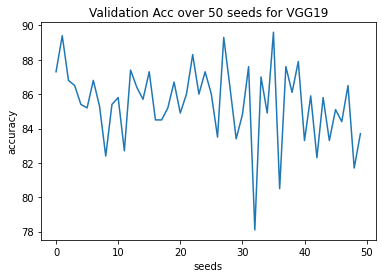

In [10]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Validation Acc over 50 seeds for VGG19');
plt.savefig('vgg19_50seeds.png')